# Part 1

In [1]:
from plotnine import ggplot, aes, geom_line, labs, theme_bw, scale_color_identity
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

RGB to Hex

In [3]:
import seaborn as sns

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


col_number = 0
a = sns.color_palette('pastel')[col_number]
rgb_colors = list(map(int, np.array(a) * 255))
print(rgb_to_hex(*rgb_colors))

#a1c9f4


In [4]:
def method_1(G):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    powers = [np.linalg.matrix_power(A, i) for i in range(0, n)]
    return np.all(sum(powers)) > 0

def method_2(G):
    return nx.algebraic_connectivity(G, method='lanczos') > 0

def method_3(G):
    return nx.is_connected(G)



def check_time(seq_k, graph_type, p=None, r=None):

    time_1, time_2, time_3 = [], [], []
    connect_1, connect_2, connect_3 = [], [], []

    for k in tqdm(seq_k):
        # Define graph type.
        if graph_type == 'ER':
            G = nx.erdos_renyi_graph(k, p, seed=90)
        elif graph_type == 'rrg':
            G = nx.random_regular_graph(r, k, seed=70)
        else: 
            print('Invalid value for graph_type!')

        # Method 1: Check irreducibility of the adjacency matrix.
        start_time = time.time()
        check_1 = method_1(G)
        end_time = time.time()
        time_1.append(end_time - start_time)
        connect_1.append(check_1)

        # Method 2: Check second lowest eigenvalue.
        start_time = time.time()
        check_2 = method_2(G)
        end_time = time.time()
        time_2.append(end_time - start_time)
        connect_2.append(check_2)

        # Method 3: Check connectivity using breadth-first search algorithm.
        start_time = time.time()
        check_3 = method_3(G)
        end_time = time.time()
        time_3.append(end_time - start_time)
        connect_3.append(check_3)

    time_data = pd.DataFrame({'k':seq_k, 'Irreducibility': time_1, 'Eigenvalue_of_L': time_2, 'BFS': time_3})

    return time_data, connect_1, connect_2, connect_3

In [24]:
seq_k = np.arange(5, 300, 20)
time_data, x,y,z = check_time(seq_k, 'ER', p=0.3, r=None)

100%|██████████| 15/15 [04:18<00:00, 17.21s/it]


In [22]:
# Check connectivity with all 3 methods.
for i in range(len(x)):
    if x[i] != y[i] or x[i] != z[i] or y[i] != z[i]:
        print(f'k={i}, x={x[i]}, y={y[i]}, z={z[i]}')

## 2) - 3) Time plot for different k

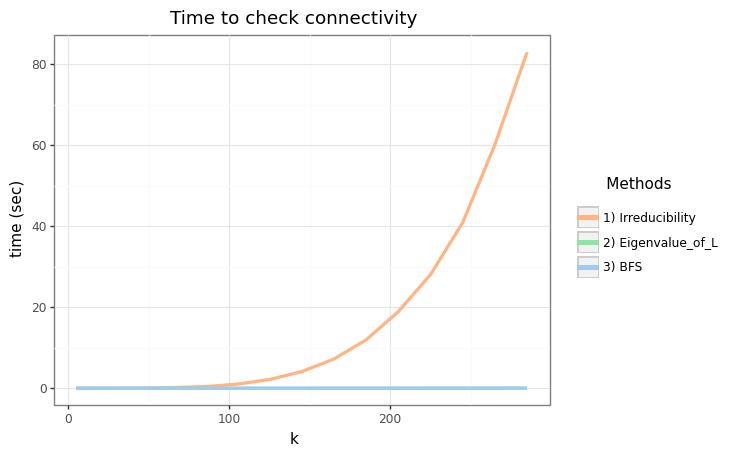

<ggplot: (131771784817)>

In [25]:
line_size = 1.3

( ggplot(time_data) +
  aes(x='k') +
  geom_line(aes(y='Irreducibility', color = '"#FFB482"'), size = line_size) +
  geom_line(aes(y='Eigenvalue_of_L', color = '"#8DE5A1"'), size = line_size) +
  geom_line(aes(y='BFS', color = '"#A1C9F4"'), size = line_size) +
  labs(x='k', y='time (sec)', title = 'Time to check connectivity') + 
  theme_bw() + 
  scale_color_identity(guide='legend', name = '      Methods \n\n ', breaks=['#FFB482','#8DE5A1','#A1C9F4'],
                       labels=['1) Irreducibility','2) Eigenvalue_of_L','3) BFS']))


Given that we found that the method 3 is the fastest, we use it to check connectivity for the next point.

## 4) 

In [24]:
def estimate_pc_er(seq_p, k, num_instances):
    pc_list = []
    for p in tqdm(seq_p):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.erdos_renyi_graph(k, p)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
k = 100
num_instances = 100
seq_p = np.linspace(0, 1, num=100)

# Estimate pc for Erdos-Reyni graphs.
pc_er = estimate_pc_er(seq_p, k, num_instances)

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


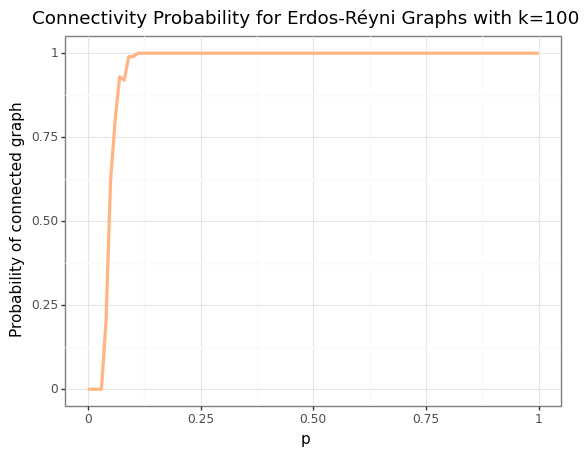

<ggplot: (324267201)>

In [25]:
# Plot pc vs p for Erdos-Reyni graphs.
( ggplot(aes(x = seq_p, y = pc_er))+
  labs(x='p',
       y='Probability of connected graph',
       title = 'Connectivity Probability for Erdos-Réyni Graphs with k=100') +
  geom_line(size=line_size, color = '#FFB482') +
  theme_bw())#.draw()

In [26]:
def estimate_pc_regular(r, k, num_instances):
    pc_list = []
    for k_val in tqdm(range(r+1, k+1)):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.random_regular_graph(r, k_val)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
r_values = [2, 8]
num_instances = 200
k = 100

# Estimate pc for regular random graphs.
pc_reg = []
for r in r_values:
    pc_r = estimate_pc_regular(r, k, num_instances)
    pc_reg.append(pc_r)

100%|██████████| 92/92 [00:20<00:00,  4.45it/s]


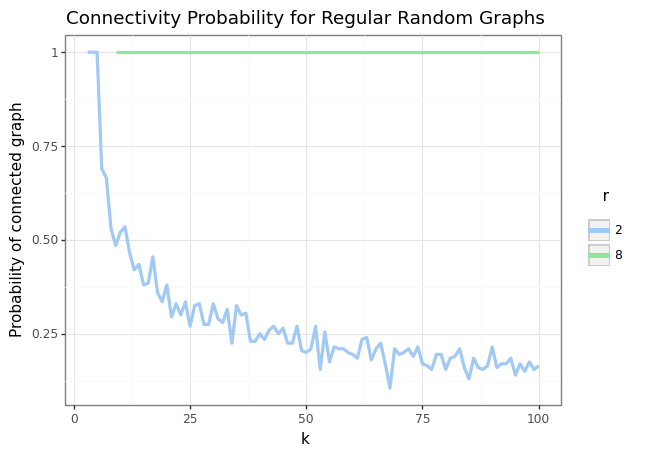

<ggplot: (324267117)>

In [27]:
# Plot pc vs k for regular random graphs.
( ggplot() +
  aes(x = np.arange(r_values[0]+1, k+1)) +
  labs(x='k',
        y='Probability of connected graph',
        title = 'Connectivity Probability for Regular Random Graphs') +
  geom_line(aes(y=pc_reg[0], color = '"#A1C9F4"'), size=line_size) +
  geom_line(aes(x = np.arange(r_values[1]+1, k+1),y= pc_reg[1], color='"#8DE5A1"'), size=line_size ) +
  theme_bw() +
  scale_color_identity(guide='legend', name = '   r \n\n ', breaks=['#A1C9F4','#8DE5A1'], labels=['2','8']))#.draw()

# Part 2

1. Select N servers that are closest to server A in the given Data Center network topology. These servers are numbered from 1 to N based on their hop count from server A.

2. Split the computation job into N parallel tasks, each of which is assigned to one of the N servers.

3. For each server i (i = 1, ..., N), calculate the time Ti required to transfer data to and from server A using the TCP connection with average throughput θi. Ti is calculated as Ti = 2τhi, where hi is the number of hops between server A and server i.

4. For each server i (i = 1, ..., N), calculate the time Xi required to run the computation task assigned to that server. Xi is a negative exponential random variable with mean E[Xi] = E[X]/N.

5. For each server i (i = 1, ..., N), calculate the amount of data Li that is transferred to and from server i. Li is equal to Lf/N.

6. For each server i (i = 1, ..., N), calculate the amount of output data Lo,i produced by that server, which is uniformly distributed in the interval [0, 2Lo/N].

7. Calculate the completion time Ri for each server i as the sum of Ti, Xi, and the time required to transfer the output data Lo,i back to server A.

8. The response time R is defined as the maximum completion time among all servers, since the output of the job is available only when all servers have delivered their output files to server A.

9. Repeat steps 2-8 multiple times to obtain a sample of response times.

10. Calculate the mean response time by averaging the sample of response times obtained in step 9.

11. The Job running cost S can be evaluated using the mean response time E[R] and the average server time used to run the job E[Θ]. The value of E[Θ] depends on whether the job runs locally on server A or is split into N tasks and run on N servers. If the job runs locally on A, then E[Θ] is equal to the time taken to run the job on server A. Otherwise, E[Θ] is the sum of the times taken to run the N tasks on the N servers. The value of S can be calculated as S = E[R] + ξ E[Θ], where ξ is a parameter that represents the cost of using server A relative to the cost of using the other N servers.

In [11]:
from plotnine import ggplot, aes, geom_line, labs, theme_bw, scale_color_identity
import matplotlib.pyplot as plt 
from scipy.stats import expon
import networkx as nx
from tqdm import tqdm
import numpy as np
import random
import fnss

Components:

- `A`: starting server
- `X`: Negative Exponential random variable
- `N`: number of servers used closest to A to split the job
- `mean_X`: E[X_i] = E[X] / N
- `C`: capacity of each link of the DC network
- `L_f`: size of input data file
- `L_o`: size of output data file
- `T_0`: fixed setup time
- `tau`: costant
- `ξ`: costant (xi)
- `T_i`: is the RTT between the origin server A and server i with $T_i = 2 \tau h_i$
- `h_i`: number of hops between server A and server i 
- Each server receive ana amount of input data `L_f / N`
- Amount of output data produced by each server is a random variable $L_{0,i} \sim Unif(0, 2 * L_0 / N)$
- Average throughput $\theta_i = C \frac{\frac{1}{T_i}}{\sum_{j=1}^N \frac{1}{T_j}}$
- The `response time R` is the time elapsing since when the job is submitted to server A until the output of the job is available at server A
- `f`: fraction of original data to add to the application job data
- $\Theta$

In [12]:
n = 64
r = int(n / 2)

## Fat-tree Networks

- Switches $\longrightarrow 5 \cdot n^2$
- Servers $\longrightarrow n^3$

In [16]:
def fat_tree_generator(n):
    
    # Generate Fat Tree graph.
    fnss.DatacenterTopology.node = property(lambda self: self.nodes)
    G = fnss.fat_tree_topology(n)

    # Replace 'host' labels with 'server'.
    for node in G.nodes():
        if G.nodes[node]['type'] == 'host':
            G.nodes[node]['type'] = 'server'

    return G


def jellyfish_generator(r, n):

    # Generate Random Regular graph.
    G = nx.random_regular_graph(r, n)

    # Set labels.
    node_attributes = {node: {'type': 'switch'} for node in G.nodes}
    nx.set_node_attributes(G, node_attributes)

    # Add servers.
    for i in range(n, (n * r) + n):
        G.add_node(i, type = 'server')

    servers = [node for node in G.nodes() if G.nodes[node]['type'] == 'server']

    # Connect servers to switches.
    counter = r
    for i in range(n):
        for j in range(counter - r, counter):
            G.add_edge(i, servers[j])
        counter += r
    
    return G

In [17]:
# Generate Fat Tree graph.
G_ft = fat_tree_generator(n)

# Check number of servers and switches.
count_server_ft = sum(1 for node in G_ft.nodes() if G_ft.nodes[node]['type'] == 'server')
count_switch_ft = sum(1 for node in G_ft.nodes() if G_ft.nodes[node]['type'] == 'switch')
print(f'Number of servers: {count_server_ft}')
print(f'Number of switches: {count_switch_ft}')

Number of servers: 65536
Number of switches: 5120


## Jellyfish Networks 

- S $\longrightarrow$ switches
- S(n-r) $\longrightarrow$ maximum number of servers
- n $\longrightarrow$ number of ports for each switch
- r $\longrightarrow$ number of ports of a switch dedicated to other switches
- (n-r) $\longrightarrow$ number of ports of a switch dedicated to servers

In [18]:
n_switch_r_regular = int(count_server_ft / (n/2))
G_jelly = jellyfish_generator(r, n_switch_r_regular)

# Check number of servers and switches.
count_server_ft = sum(1 for node in G_jelly.nodes() if G_jelly.nodes[node]['type'] == 'server')
count_switch_ft = sum(1 for node in G_jelly.nodes() if G_jelly.nodes[node]['type'] == 'switch')
print(f'Number of servers: {count_server_ft}')
print(f'Number of switches: {count_switch_ft}')

Number of servers: 65536
Number of switches: 2048


In [19]:
max_degree_node = max(G_jelly.degree(), key=lambda x: x[1])[1]
min_degree_node = min(G_jelly.degree(), key=lambda x: x[1])[1]

switch_nodes = [node for node in G_jelly.nodes() if G_jelly.nodes[node]['type'] == 'switch']
min_degree_switch = min([G_jelly.degree(node) for node in switch_nodes])

print(f'Max degree: {max_degree_node} \nMin degree: {min_degree_node}')
print(f'\nMin switch degree: {min_degree_switch}')

Max degree: 64 
Min degree: 1

Min switch degree: 64


## Algorithm to run the Simulation

In [20]:
# Data.
C = 1e10
tau = 1e-6
Lf = 4 * 8e12
Lo = 4 * 8e12
E_X = 8 * 3600
T_0 = 30
xi = .1
f = 48 / 1500

In [21]:
# Find hops between A and i servers.
def find_hopes(G, A, N):
    distances = nx.single_source_shortest_path_length(G, A)
    sorted_nodes = sorted(distances, key=distances.get)
    server_nodes = [(n, distances[n]) for n in sorted_nodes if G.nodes[n]['type'] == 'server']
    return server_nodes[1:N+1]


# Find T_i given hops from the node A.
def find_T_i(G, N, A):
    A_hops = find_hopes(G, A, N)
    T_i = [2 * tau * hop[1] for hop in A_hops]
    return np.array(T_i)


# Compute theta_i given T_i.
def find_theta_i(T_i, C):
    T_i = np.array(T_i)
    theta_i = C * ((1 / T_i) / sum(1 / (T_i)))
    return theta_i


# Generate N random values Lo_i.
def find_Lo_i(Lo, N):
    Lo_i = np.random.uniform(0, 2*Lo/N, size=N)
    return Lo_i


# Compute Response Time.
def response_time(G, N, A, C, T_0, Lf, Lo, E_X, f):

    # Compute theta_i.
    T_i = find_T_i(G, N, A)
    theta_i = find_theta_i(T_i, C)

    # Compute Lo_i.
    Lo_i = find_Lo_i(Lo, N)

    # Generate N values from Negative Exponential.
    rv = expon(scale = (E_X/N))
    X_i = rv.rvs(size=N)
    # X_i = [-E_X / n * np.log(1 - x) for x in [random.random() for _ in range(N)]]

    # Response time.
    R = max( (1+f) * Lf / (N * theta_i)   +   T_0 + X_i   +   (1+f) * Lo_i / theta_i )

    return R


# Run a simulation for R over N.
def simulation_R(G, M, list_N, C, T_0, Lf, Lo, E_X, f):
    server_nodes = [node for node in G.nodes() if G.nodes[node]['type'] == 'server']
    list_A = random.sample(server_nodes, M)

    simulations = []
    for N in tqdm(list_N):
        list_R = [response_time(G, N, A, C, T_0, Lf, Lo, E_X, f) for A in list_A]
        simulations.append(np.mean(list_R))
    
    return np.array(simulations)

In [22]:
# Baseline
R_baseline = T_0 + E_X

# Simulation paramters.
M = 10
list_N = np.arange(1, 10_001, 200)

# Simulation.
ft_simulation = simulation_R(G_ft, M, list_N, C, T_0, Lf, Lo, E_X, f)
jelly_simulation = simulation_R(G_jelly, M, list_N, C, T_0, Lf, Lo, E_X, f)

# Normalization.
ft_simulation_norm = ft_simulation / R_baseline
jelly_simulation_norm = jelly_simulation / R_baseline

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


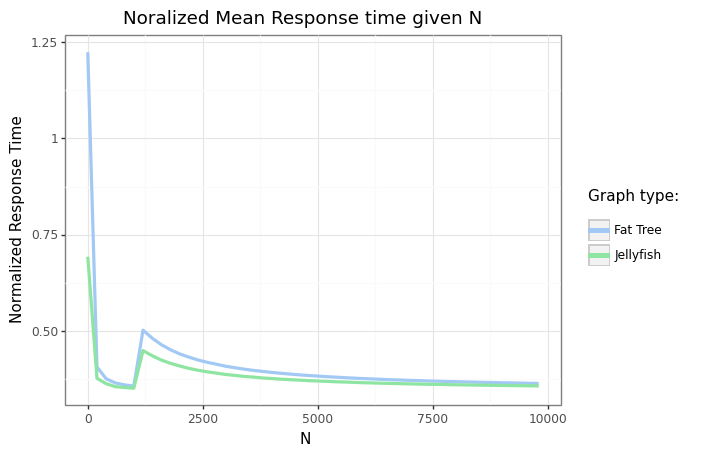

<ggplot: (131771771376)>

In [23]:
line_size = 1.3

( ggplot() +
  aes(x = list_N) +
  labs(x='N',
        y='Normalized Response Time',
        title = 'Noralized Mean Response time given N ') +
  geom_line(aes(y=ft_simulation_norm, color = '"#A1C9F4"'), size=line_size) +
  geom_line(aes(x = list_N, y= jelly_simulation_norm, color='"#8DE5A1"'), size=line_size ) +
  theme_bw() +
  scale_color_identity(guide='legend', name = 'Graph type: \n\n ', breaks=['#A1C9F4','#8DE5A1'], labels=['Fat Tree','Jellyfish']))#.draw()